## ssRNA data exploration/annotation/dataset integration example

### Outline & rationale
I had already planned some time getting to grips with scRNA analysis, and this felt like a better use of time than tidying up old code, so 
I decided to tackle a scRNA task using Seurat - I happened to have some read-count level datasets available from a colleague (he'd used them as part of a problem for MSc students).

### Objectives:
- process data
- Build a Shiny App to explore cell QC/pick cell filter criteria
- integrate datasets (three batches, from two technologies - see below)
- Initial exploration of results


### Compute
Although these datasets aren't huge, they were too much for my laptop (due to memory limitations), and so I 
used a Google Compute instance.  
I ran Seruat v5.2.0 in R.  
The Shiny app is currently running, and should be accessible on:  
https://2b326c3c59d73e49-dot-europe-west2.notebooks.googleusercontent.com/proxy/3838/

### Datasets
scRNA from mouse embryos at various developmental stages.  
Three datasets, from two publications, each supplied as a csv file giving RNA read counts for each gene (rows) per cell (columns).  
Both publications label genes using ENSEMBL stable IDs  

Argelaguet et al. Multi-omics profiling of mouse gastrulation at single-cell resolution. Nature, 576, 2019. doi:
10.1038/s41586-019-1825-8 
- One dataset, with data derived from single-cell FACS or manual sorting
  
Pijuan-Sal ,et al. A single-cell molecular map of mouse gastrulation and early
organogenesis. Nature, 566, 2019. ISSN 14764687. doi: 10.1038/s41586-019-0933-9
- Two datasets, with data derived from 10X


### Processing plan:
1. Load csv and convert to Seurat object
2. Descriptive plots visualised through shiny app
3. Cell filtering

### Initial exploration with Arg1 data, to develop techniques

In [1]:
library(data.table)
library(Seurat)
library(ggplot2)
library(BPCells)
options(Seurat.object.assay.version = "v5")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




#### 1. Load csv and convert to Seurat object

both datasets use ensembl stable IDs rather than gene labels, which is good, because it will be more straightforward to compare/merge
- neither of them have version numbers on the IDs, so no need to split gene IDs at '.'

In [2]:
infile <- 'Arg_batch1.csv'
gene_col_name <- 'ens_id'

In [3]:
inputdir <- '~/data'
DT <- fread(file.path(inputdir, infile))  # load (using a fast data.table function)
mat <- as.matrix(DT[,-..gene_col_name])  # matrix from all columns other than gene ID
rownames(mat) <- DT[[gene_col_name]]  # and add the gene IDs as row names

Let's have a quick look at genes/reads present per cell

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


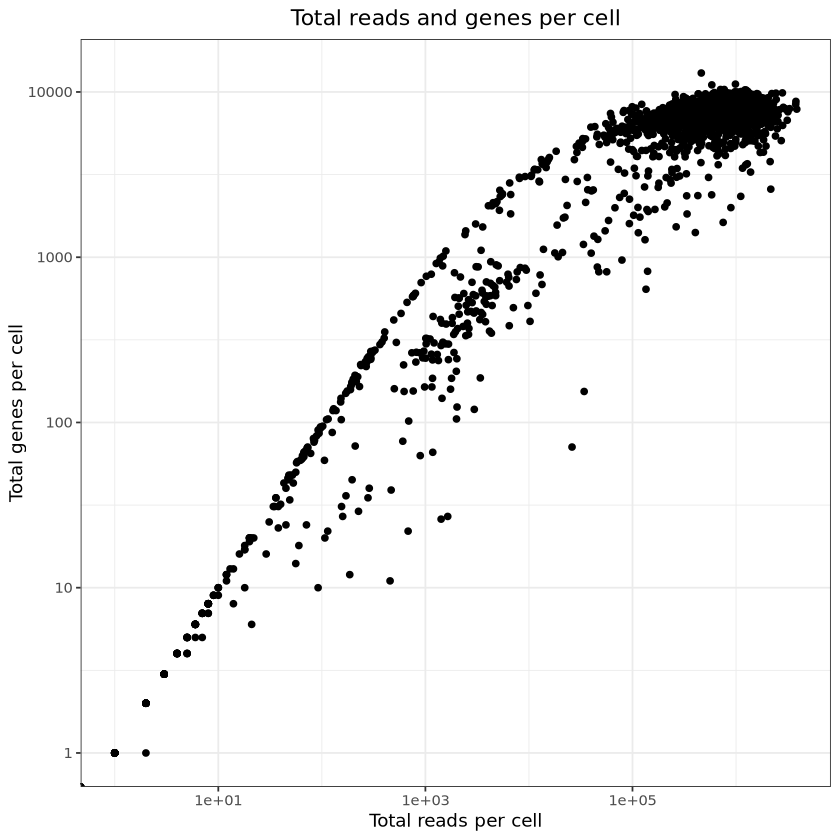

In [4]:
cells_dt <- data.table(reads=colSums(mat), genes=colSums(mat>0))
ggplot(cells_dt, aes(x=reads, y=genes)) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  theme_bw() +
  xlab('Total reads per cell') +
  ylab('Total genes per cell') +
  ggtitle('Total reads and genes per cell') +
  theme(plot.title = element_text(hjust = 0.5))

So until somewhere around at least 10000 reads/cell, a lot of the cells are close to fully read restricted (i.e. 1 extra read = 1 newly spotted gene)
- for "proper" analysis, need to think about this filtering, and whether it's better to let things handle this downstream or remove here.  For now, proceed, and redo this after cell filtering steps

In [5]:
# create the Seurat object
# no filtering here, but min.features = 1, because if any cells have zero counts for any reason,
#     Seurat will throw an exception
rna <- CreateSeuratObject(counts = mat, min.features = 1)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


NOTE: If the data files were very large, Seurat can keep them mostly on disk.  For this:
1. Convert the matrix to sparse using Matrix::Matrix(mat, sparse=TRUE)
2. Use BPCells:write_matrix_dir() to move the sparse matrix to disk
3. Use BPCells::open_matrix_dir() to map the on-disk matrix to an object
4. Use this object as counts in CreateSeuratObject()

now tidy the metadata... seurat has (correctly) taken the part of the name before the first underscore
and stored it in rna$orig.ident
- but let's also store the assay info

In [6]:
rna$timepoint <- rna$orig.ident
rna$paper <- 'Arg'
rna$batch <- 'Arg'

### 2. Cell filtering
#### 2a. Count mtRNA
- cells with a high proportion of mtRNA may be dying/dead, and are often filtered out

In [7]:
# to get a list of ensembl mitochondrial genes, I downloaded a csv from the emsembl browser.
# I ended up with duplicate rows giving ensembl id and gene label, so I'll need to process a little
mt_tab <- fread('mouse_mt_gene_ids.csv')
mt_ids <- mt_tab[gene_id %like% "^ENSMUSG"][,tstrsplit(gene_id, '.', keep=1, fixed=TRUE)][,V1]
# this selects rows where the gene_id column start as a stable ENSEML mouse ID should, drops the version number,
#   and returns a vector

# if any are not in the dataset, an exception is raised, so remove missing genes from the list first
ids_in_dataset <- dimnames(rna$RNA@features)
mt_ids_in_dataset <- mt_ids[mt_ids %in% ids_in_dataset]

if(length(mt_ids_in_dataset) == 0) {
  cat("No mitochondrial genes found in dataset")
}else{
    rna[["percent.mt"]] <- PercentageFeatureSet(rna, features = mt_ids_in_dataset)
}

No mitochondrial genes found in dataset

So, no mtRNA to count/filter on.  The paper says they threw away anything which wasn't on a
"canonical" chromosome, so presumably that includes the mt

#### 2b. plot things we might filter on - %mtRNA, number genes, number reads

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“The following requested variables were not found: percent.mt”


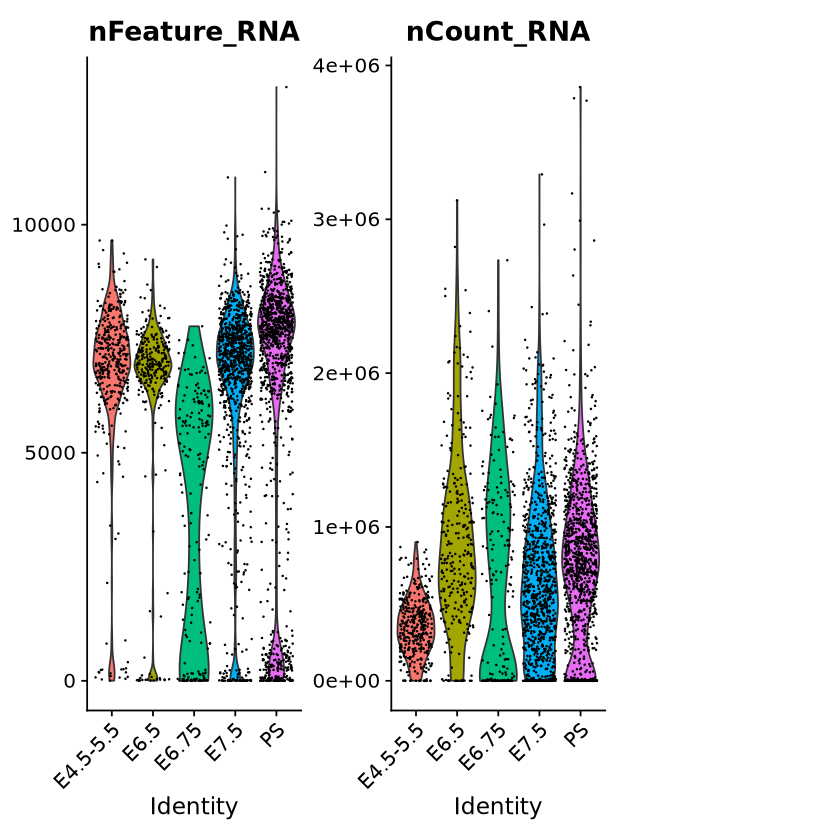

In [8]:
VlnPlot(rna, features = c("percent.mt", "nFeature_RNA", "nCount_RNA"), ncol = 3)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


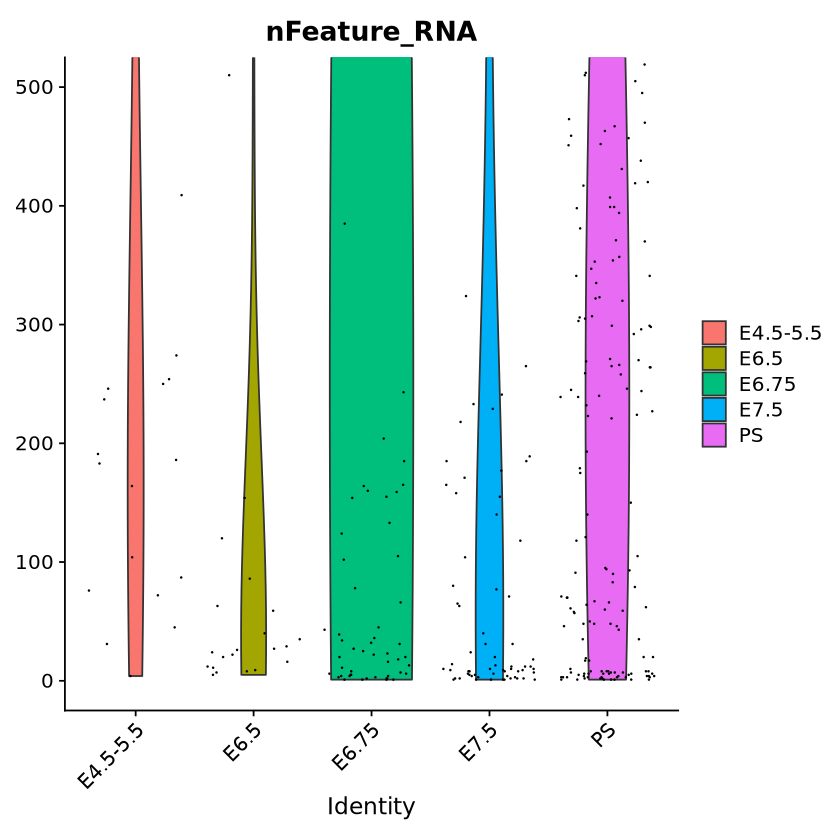

In [9]:
# zoom in a little on #genes/cell - perhaps a few hundred would be a good cutoff?
VlnPlot(rna, features = c("nFeature_RNA")) + coord_cartesian(ylim=c(0,500))

I don't want to over-filter, and it isn't clear whether I should pick <150 (very conservative), 
or something ~ 1000, to eliminate the lower group in the PS set
- let's look at gene count vs read count, to see if they tell the same story

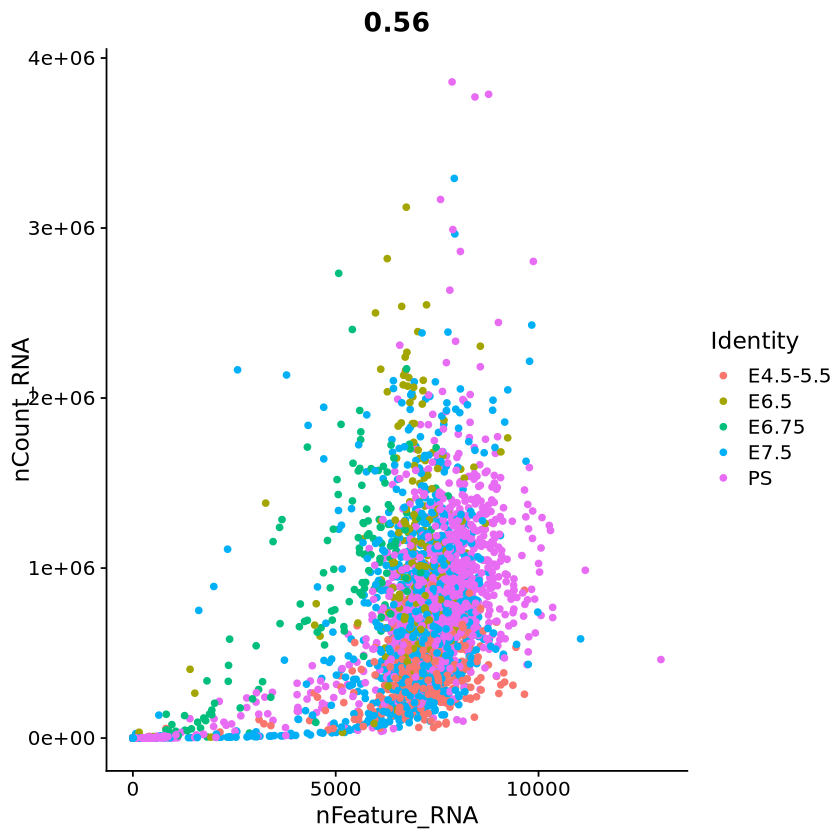

In [10]:
FeatureScatter(rna,'nFeature_RNA', 'nCount_RNA',shuffle=TRUE, pt.size = 1.5, slot = 'counts')

This hasn't made things much clearer - there does seem to be a population in PS where
the read count is higher than the gene count would suggest
- filter at <150 genes/cell, to be conservative, but this group might be something like RBC
- ideally, compare results with and without (but not now!)

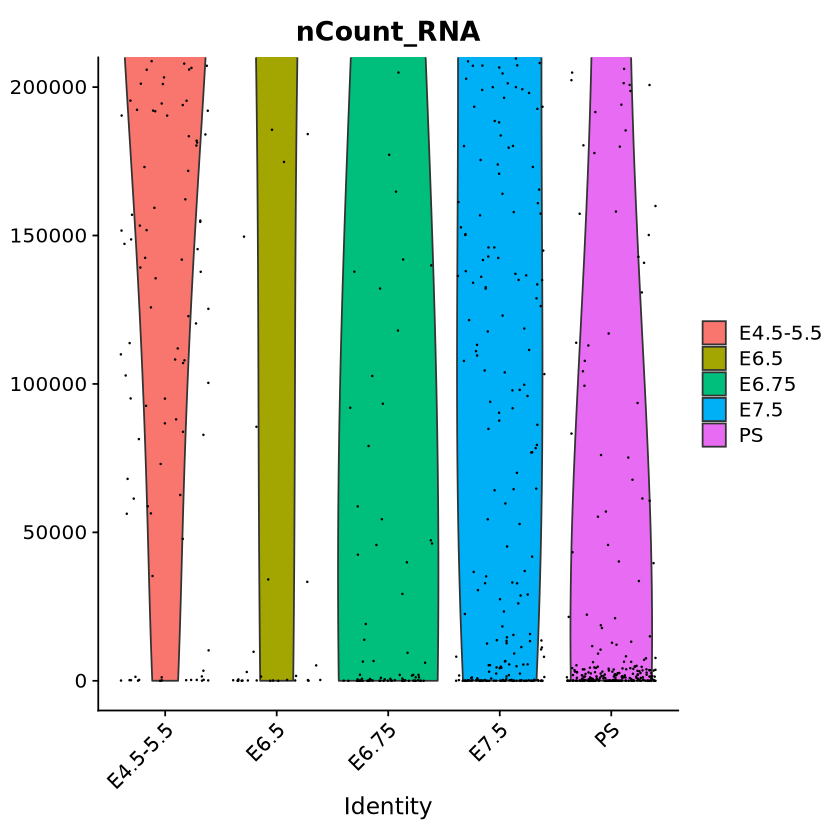

In [11]:
# zoom in on #reads/cell -
# filtering on # of features may be a good idea: zoom in the plot first
VlnPlot(rna, features = c("nCount_RNA"), layer = 'counts') + coord_cartesian(ylim=c(0,200000))

50,000 reads/cell seems reasonable (probably 10,000 would produce similar results)

#### 2c. Apply cell filters
- in this case, remove cells with <50000 reads or <150 genes

In [12]:
rna <- subset(rna, subset = nCount_RNA >= 50000 & nFeature_RNA >= 150)

### 3. Normalisation & finding variable features (using sctransform v2)


In [13]:
rna <- SCTransform(rna)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Warning message:
“replacing previous import ‘S4Arrays::read_block’ by ‘DelayedArray::read_block’ when loading ‘SummarizedExperiment’”
Variance stabilizing transformation of count matrix of size 18601 by 2535

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2535 cells

Second step: Get residuals using fitted parameters for 18601 genes

Computing corrected count matrix for 18601 genes

Calculating gene attributes

Wall clock passed: Time difference of 31.73308 secs

Determine variable features

Centering data matrix

Set default assay to SCT



In [14]:
rna

An object of class Seurat 
40685 features across 2535 samples within 2 assays 
Active assay: SCT (18601 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

### 4. Dimensionality reduction
- PCA, then examine by uMAP


In [15]:
rna <- RunPCA(rna, verbose=FALSE)

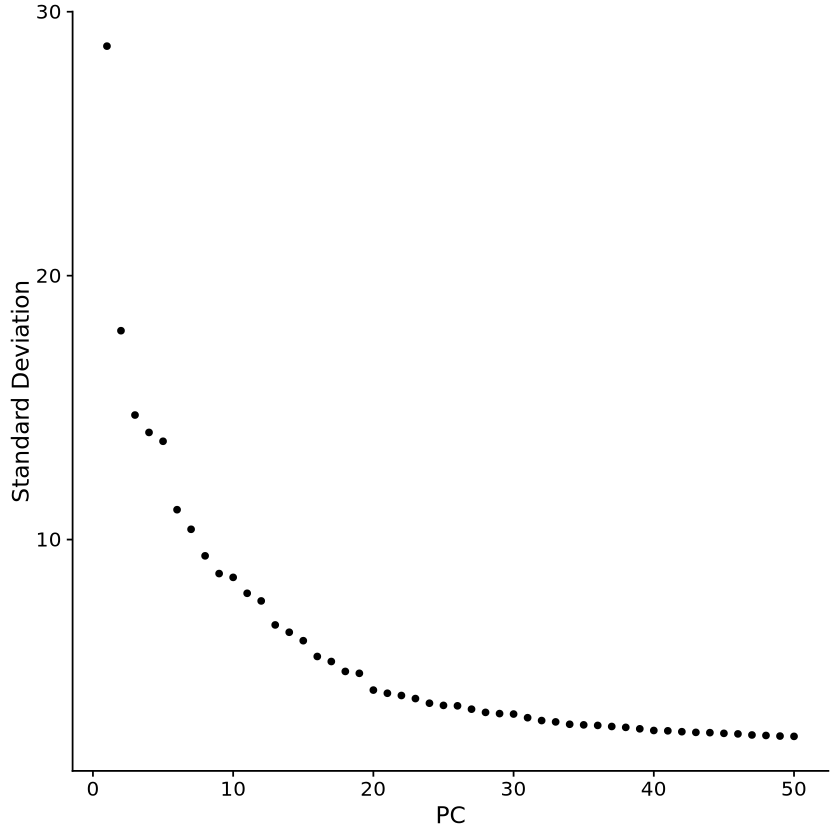

In [16]:
ElbowPlot(rna, ndims = 50, reduction = "pca")

Nothing obvious, and the docs say that picking lots of dims is usually good with 
SCTransform normalised data, so use 30, but ideally explore further

In [17]:
rna <- FindNeighbors(rnapbmc <- RunUMAP(rna, dims = 1:30, verbose = FALSE), dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [18]:
rna <- RunUMAP(rna, dims = 1:30, verbose = FALSE)

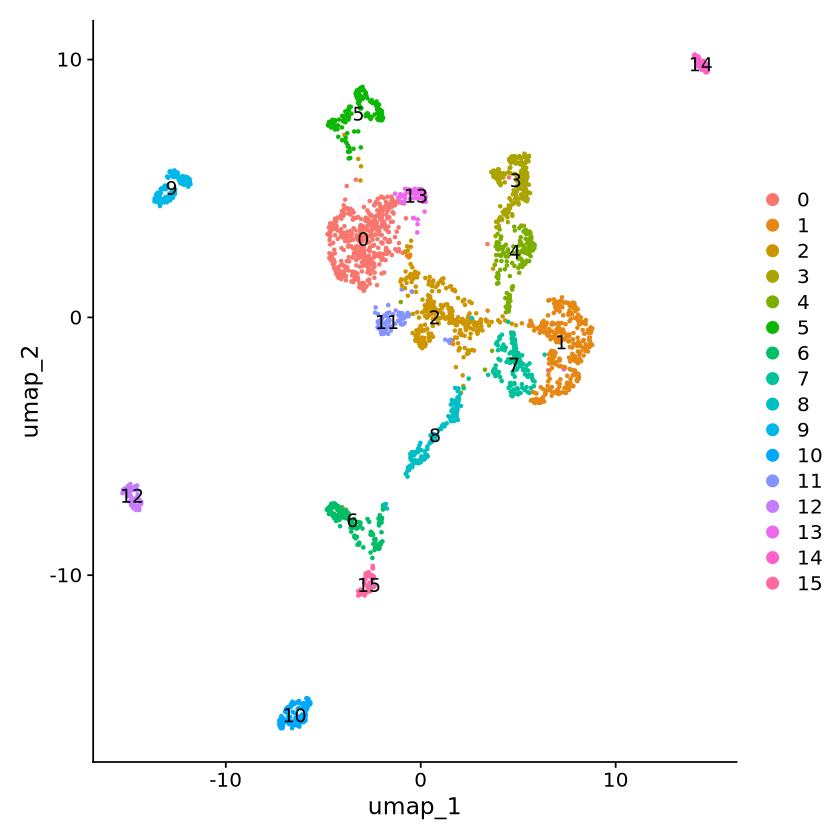

In [19]:
rna <- FindClusters(rna, verbose = FALSE)
DimPlot(rna, label = TRUE)

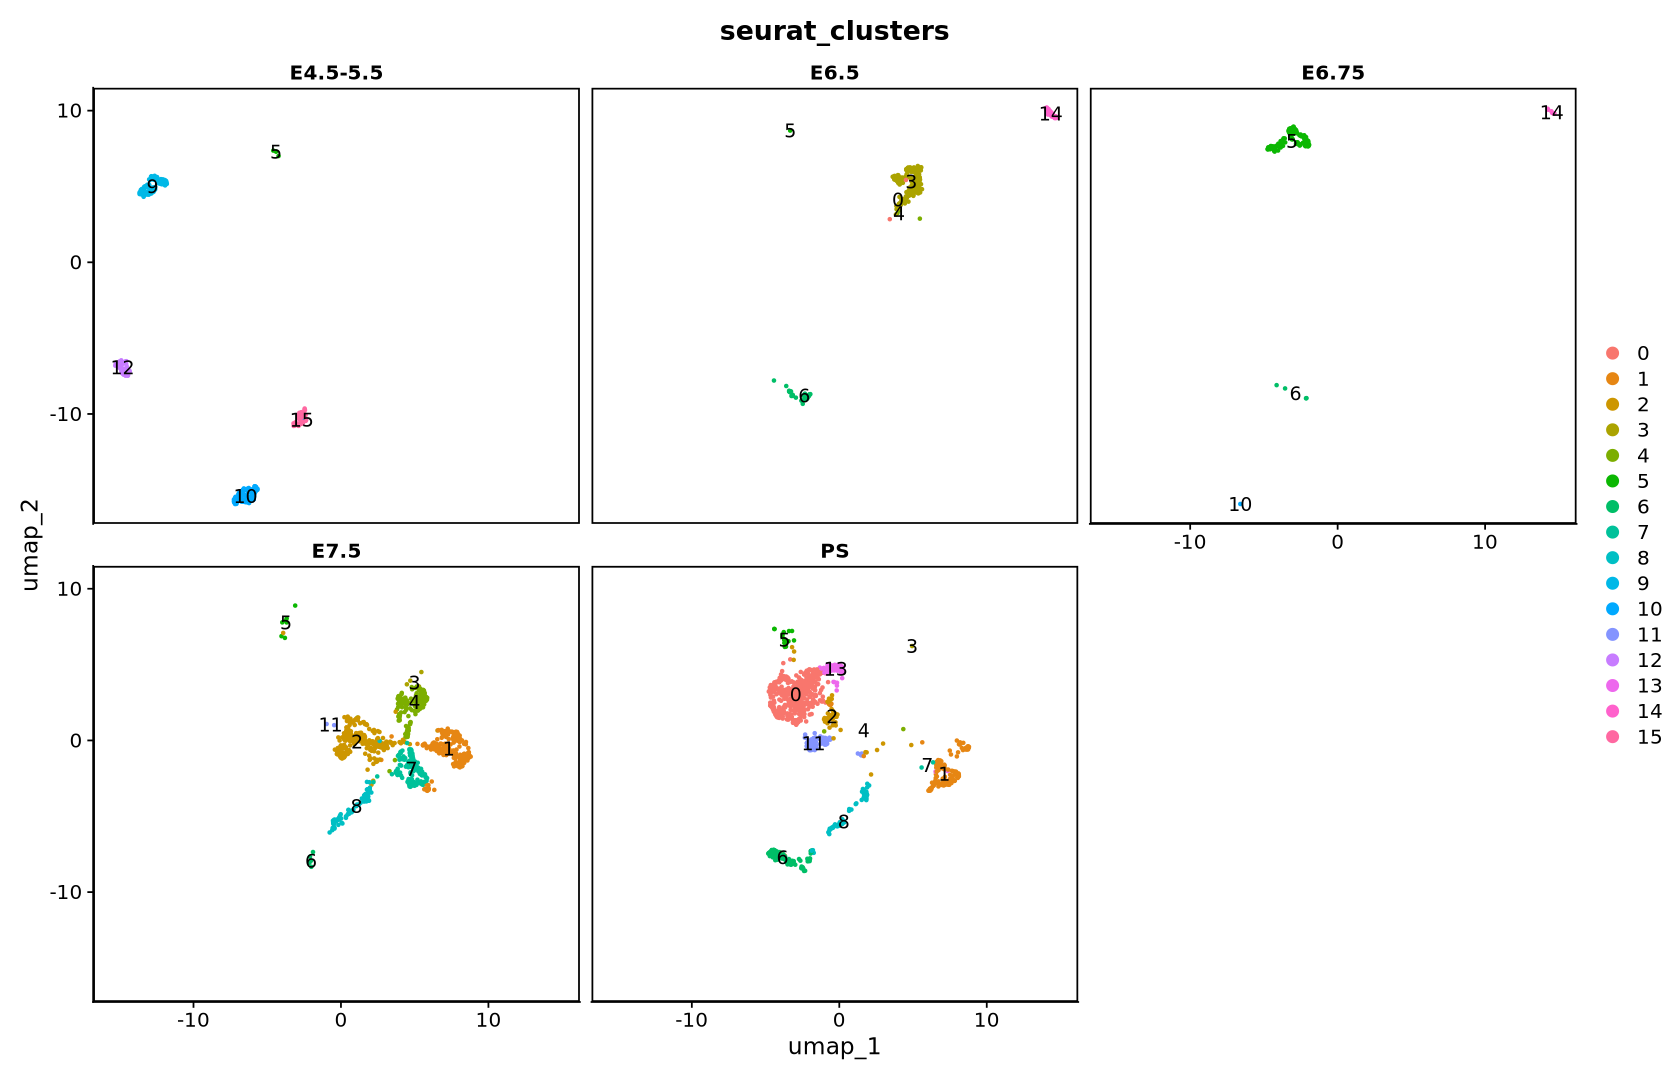

In [20]:
options(repr.plot.width = 14, repr.plot.height = 9)
DimPlot(rna, 
        group.by = "seurat_clusters",  # Color by cluster
        split.by = "orig.ident",       # Facet by sample
        label = TRUE,
        ncol = 3) + theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1))

### 5. Dataset integration
- requires the above being performed for each of the samples, then combining into a single object and integrating

#### To streamline rerunning on multiple batches:
- I wrote functions to load the csv, make seurat objects, add extra metadata from metadata csv,
  and calculate % mt DNA
- I put plotting functions into a shiny app to make the filter thresholds easy to estimate
- I wrote a function to apply filters

### For this and data integration, see `2-processing_and_integration.ipynb`